# Cluster TCGA processed FPKM and plot a heatmap with dendrograms
## For the 6 gene signatures
## Input:
1. ../results/tcga/fpkm_final_add1-log2-zscore_336.csv

## Output:
1. ../results/tcga_python/clustermap_{signature}_zscore_hc_ward_euclidean_2_3.pdf
2. ../results/tcga_python/sample_clusters_{signature}_zscore_hc_ward_euclidean_3.csv

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns # 0.9.0
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle

# Part Data
## Load data and filter for a signature
#### Load processed data

In [75]:
signature = "Ribas_10G_Interferon_Gamma" # Inflammatory, Gajewski_13G_Inflammatory, 6G_Interferon_Gamma, 
# Interferon_Gamma_Biology, T-cell_Exhaustion, Ribas_10G_Interferon_Gamma

In [87]:
df = pd.read_csv('../results/tcga/fpkm_final_add1-log2-zscore_336.csv', sep = '\t', index_col = 0)
print(df.shape) # (733, 336)
display(df.head(3))

(733, 336)


,4073-01B,A4XI-01A,AACU-01A,AACT-01A,AADJ-01A,A9H1-01A,A8HU-01A,A8O6-01A,A7SK-01A,A73E-01A,...,AAD8-01A,A7IJ-01A,A3KF-01A,AAD6-01A,AAEH-01A,A9CV-01A,A25T-01A,AAC9-01A,AA0V-01A,AAVQ-01A
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,0.335702,0.866843,-0.502767,1.388609,1.339769,2.031834,-1.138727,-0.463543,0.532709,-1.404526,...,-0.710135,0.094537,-1.435211,0.699678,0.929617,0.989206,-1.673031,1.415594,1.502492,0.351211
ACVR1C,-0.812622,-0.008923,-0.508074,0.967215,-0.296076,-0.425763,-0.587833,-0.841910,-0.628742,0.387941,...,0.604633,-0.149803,-0.549208,1.382937,0.032788,-0.507949,-0.652200,0.252184,1.247761,-0.737892
ADAM12,0.157857,-0.262157,-0.326421,-0.242689,-0.460091,-0.420556,-0.293312,-0.169956,-0.414146,-0.475654,...,0.516919,5.147880,-0.392268,-0.326480,-0.412147,-0.119115,0.139798,0.537841,-0.124999,-0.231465


#### Gene filtering by a signature

In [77]:
if signature == "Inflammatory":
    geneS = ["CD274", "CD8A", "LAG3", "STAT1"]
elif signature == "Gajewski_13G_Inflammatory":
    geneS = ["CCL2","CCL4","CD8A","CXCL10","CXCL9","GZMK","HLA-DMA","HLA-DMB","HLA-DOA","HLA-DOB","ICOS","IRF1"]
elif signature == "6G_Interferon_Gamma":
    geneS = ["CXCL10","CXCL9","HLA-DRA","IDO1","IFNG","STAT1"]
elif signature == "Interferon_Gamma_Biology":
    geneS = ["CCL5","CD27","CXCL9","CXCR6","IDO1","STAT1"]
elif signature == "T-cell_Exhaustion":
    geneS = ["CD274","CD276","CD8A","LAG3","PDCD1LG2","TIGIT"]
elif signature == "Ribas_10G_Interferon_Gamma":
    geneS = ["CCR5","CXCL10","CXCL11","CXCL9","GZMA","HLA-DRA","IDO1","IFNG","PRF1","STAT1"]

In [78]:
df = df.loc[geneS]

# Part Functions
##### Clustering and plot heatmap with dendrograms

In [54]:
def plot_data(data=None, precomp=True, clusters_row=None, clusters_col=None, method="ward", 
              metric="euclidean", cmap="PiYG", figsize=(288, 72), dpi=100):
    """
    If precomp = True, precomputed clusters of both rows and columns have to be passed.
    Should be cut trees, so it shows the full dendrogram (calculated in the function) 
    with the fixed groups you want.
    The data will be scaled into [-1, 1] only for visualization.
    
    Otherwise, let the function perform the clustering while trying to plot clustermap, 
    for further processing on the dendrogram.
    """
    
    # if there are clusters input, set the colors for them
    if clusters_row is not None:
#         colors_row = matplotlib.cm.rainbow(np.linspace(0, 1, len(clusters_row.unique())))
        colors_row = [matplotlib.cm.Paired(i) for i in range(len(clusters_row.unique()))]
        lut_row = dict(zip(clusters_row.unique(), colors_row))
        row_colors = clusters_row.map(lut_row)
        row_colors.name = "Gene cluster"

    else:
        row_colors = None

    if clusters_col is not None:
        # set sample cluster color: red for High, blue for Median, green for Low
        if 'Cluster High' in clusters_col.values:
            lut_col = {'Cluster High': matplotlib.cm.Set1(0), 
                       'Cluster Median': matplotlib.cm.Set1(1),
                       'Cluster Low': matplotlib.cm.Set1(2)}
        else:
    #         colors_col = matplotlib.cm.rainbow(np.linspace(0, 1, len(clusters_col.unique())))
            colors_col = [matplotlib.cm.Paired(i) for i in range(len(clusters_col.unique()))]
            lut_col = dict(zip(clusters_col.unique(), colors_col))
        col_colors = clusters_col.map(lut_col)
        col_colors.name = "Sample cluster"

    else:
        col_colors = None
        

    if precomp: # scale values to [-1, 1], only for visualization
        col_linkage = hierarchy.linkage(distance.pdist(data.T, metric=metric), method=method)
        row_linkage = hierarchy.linkage(distance.pdist(data, metric=metric), method=method)

        min_max_scaler = MinMaxScaler(feature_range=[-1, 1]) 
        x_scaled = min_max_scaler.fit_transform(data.T.values)
        data_scaled = pd.DataFrame(x_scaled.T, columns=data.columns, index=data.index)

        cm = sns.clustermap(data_scaled, col_linkage=col_linkage, row_linkage=row_linkage, method=method, metric=metric, 
                            z_score=None, xticklabels=True, cmap=cmap, figsize=(figsize[0],figsize[1]*1.5), 
                            row_colors=row_colors, col_colors=col_colors)
    else: # first try of clustering for further tree cut
        cm = sns.clustermap(data, method=method, metric=metric, z_score=None, xticklabels=True, cmap=cmap, 
                            figsize=figsize, row_colors=row_colors, 
                            col_colors=col_colors, row_cluster=True, col_cluster=True)
    
    # Use the dendrogram box to reposition the color bar      
    dendro_box = cm.ax_row_dendrogram.get_position()
    dendro_box_row = cm.ax_row_dendrogram.get_position()
    dendro_box_col = cm.ax_col_dendrogram.get_position()

    dendro_box.x0 = dendro_box_col.x1 + (dendro_box_row.x1 - dendro_box_row.x0)*3
    dendro_box.x1 = dendro_box.x0 + (dendro_box_row.x1 - dendro_box_row.x0)/2
    cm.cax.set_position(dendro_box)
    # set title for the color bar
    cm.cax.set_title('Normalized FPKM Matrix', fontsize=100)
    
    # Increase the height of col dendrogram to aviod being cut off or condensed
    cm.ax_col_dendrogram.set_position([dendro_box_col.x0, dendro_box_col.y0, 
                                       dendro_box_col.width, dendro_box_col.height*15])
    
    # Adjust the colormap labels
    cm.cax.tick_params(labelsize=150, labelrotation=0)
    
    # If there are clusters input, further configuration for the dendrograms and legends
    if clusters_row is not None:
        for cluster in sorted(clusters_row.unique()):
            cm.ax_row_dendrogram.bar(0, 0, color=lut_row[cluster], label=cluster, linewidth=0)
            lrow = cm.ax_row_dendrogram.legend(title='Gene Clusters', loc="lower center", ncol=1, fontsize=150, 
                                               bbox_to_anchor=(dendro_box_row.x1, 
                                                               (dendro_box_col.y0+dendro_box_col.y1)/2), 
                                               bbox_transform=plt.gcf().transFigure)
            lrow.get_title().set_fontsize('180')

        for tick_label in cm.ax_heatmap.axes.get_yticklabels():
            tick_text = tick_label.get_text()
            tick_name = clusters_row.loc[tick_text]
            tick_label.set_color(lut_row[tick_name])
            
        # Adjust the gene labels
        cm.ax_heatmap.tick_params(axis='y', labelsize=200, labelrotation=0)

        ax1 = cm.ax_row_colors
        for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
            item.set_fontsize(180)
            item.set_rotation(0)
            item.set_horizontalalignment("right")

        rec1 = 0
        for i in range(1, len(set(clusters_row))+1):
            rec1 = rec1 + (clusters_row == i).sum()
#                 if i==3 or i == 4 or i == 5:
#                     edgecolor = "k"
#                 else:
#                     edgecolor = "w"
            edgecolor = "w"
            cm.ax_heatmap.add_patch(Rectangle((0, 0), data.shape[1], rec1, fill=False, edgecolor=edgecolor, lw=10))

    if clusters_col is not None:
        for cluster in sorted(clusters_col.unique()):
            cm.ax_col_dendrogram.bar(0, 0, color=lut_col[cluster], label=cluster, linewidth=0)
            lcol = cm.ax_col_dendrogram.legend(title='Sample Clusters', loc="lower left", ncol=1, fontsize=150, 
                                               bbox_to_anchor=(dendro_box_col.x1, (dendro_box_col.y0+dendro_box_col.y1)/2), 
                                               bbox_transform=plt.gcf().transFigure)
            lcol.get_title().set_fontsize('180')

        for tick_label in cm.ax_heatmap.axes.get_xticklabels():
            tick_text = tick_label.get_text()
            tick_name = clusters_col.loc[tick_text]
            tick_label.set_color(lut_col[tick_name])
         
        # Adjust the sample labels
        cm.ax_heatmap.tick_params(axis='x', labelsize=20)

        ax2 = cm.ax_col_colors
        for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(180)

        rec2 = 0
        edgecolor = "w"
        for i in range(1, len(set(clusters_col))+1):
            rec2 = rec2 + (clusters_col == i).sum()
            cm.ax_heatmap.add_patch(Rectangle((0, 0), rec2, data.shape[0], fill=False, edgecolor=edgecolor, lw=10))
        
    # fix the problem that the top and bottom cells are cut off
    bottom, top = cm.ax_heatmap.get_ylim()
    cm.ax_heatmap.set_ylim(bottom + 0.5, top - 0.5)
    
    # set all legend fonts to Arial
    matplotlib.rc('font',family='Arial') # change the default fontname for all the text, actually for the label
    print(matplotlib.rcParams['font.family']) # necessary for the title and axis. But if not install the package, print "Arial" without using it

    plt.savefig("../results/tcga_python/clustermap_{}_zscore_hc_{}_{}_2_3.pdf".format(signature, method, metric), bbox_inches = "tight")
    plt.show()
       
    return(data, cm) # return processed data and the clustergrid in case dendrogram need further processing

##### Plot advanced dendrogram

In [42]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    orientation = kwargs.get('orientation')
    truncate_mode = kwargs.get('truncate_mode')
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)', fontsize=200)
        if orientation == 'top':
            plt.xlabel('sample index or (cluster size)', fontsize=200)
            plt.ylabel('distance', fontsize=200)
            if truncate_mode is None:
                plt.xticks(fontsize=80)
            else: 
                plt.xticks(fontsize=200)
            plt.yticks(fontsize=200)
            for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
                x = 0.5 * sum(i[1:3])
                y = d[1]
                if y > annotate_above:
                    plt.plot(x, y, 'o', c=c)
                    plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                                 textcoords='offset points',
                                 va='top', ha='center', fontsize=100)
        elif orientation == 'left':
            plt.ylabel('sample index or (cluster size)', fontsize=200)
            plt.xlabel('distance', fontsize=200)
            plt.xticks(fontsize=200)
            if truncate_mode is None:
                plt.yticks(fontsize=10)
            else:
                plt.yticks(fontsize=200)
            for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
                x = 0.5 * sum(i[1:3])
                y = d[1]
                if x > annotate_above:
                    plt.plot(y, x, 'o', c=c)
                    plt.annotate("%.3g" % y, (y, x), xytext=(0, -5),
                                 textcoords='offset points',
                                 va='top', ha='center', fontsize=100)
        if max_d:
            if orientation == 'top':
                plt.axhline(y=max_d, c='k')
            if orientation == 'left':
                plt.axvline(x=max_d, c='k')
    return ddata

##### Get the clusters

In [43]:
def retrieve_cluster(data, cm, gene_or_sample, threshold, criterion="distance"): 
    if gene_or_sample == "gene":
        linkage = cm.dendrogram_row.linkage
    else:
        linkage = cm.dendrogram_col.linkage
    clusters = fcluster(Z=linkage, t=threshold, criterion=criterion)
    print(clusters) # for the original column index

    
    l = []
    lcluster = []
        
    clusters = pd.Series(clusters)
    if gene_or_sample == "gene":
        clusters.index=data.index
    else:
        clusters.index=data.columns
        
    for c in range(1,len(set(clusters))+1):
        if gene_or_sample == "gene":
            l.extend(np.asarray(data.index)[clusters==c])
        else:
            l.extend(np.asarray(data.columns)[clusters==c])
        lcluster.extend([c]*((clusters==c).sum()))
        
    df_clustered = pd.DataFrame(list(zip(l, lcluster)), columns=["Name", "Cluster"])
    print(df_clustered.shape)
    display(df_clustered.head(5))
    return clusters, df_clustered

# Part Execution
##### Perform hierarchical clutering for samples and genes, and get the dendrograms for further processing
The clustermap here is not important

['Arial']


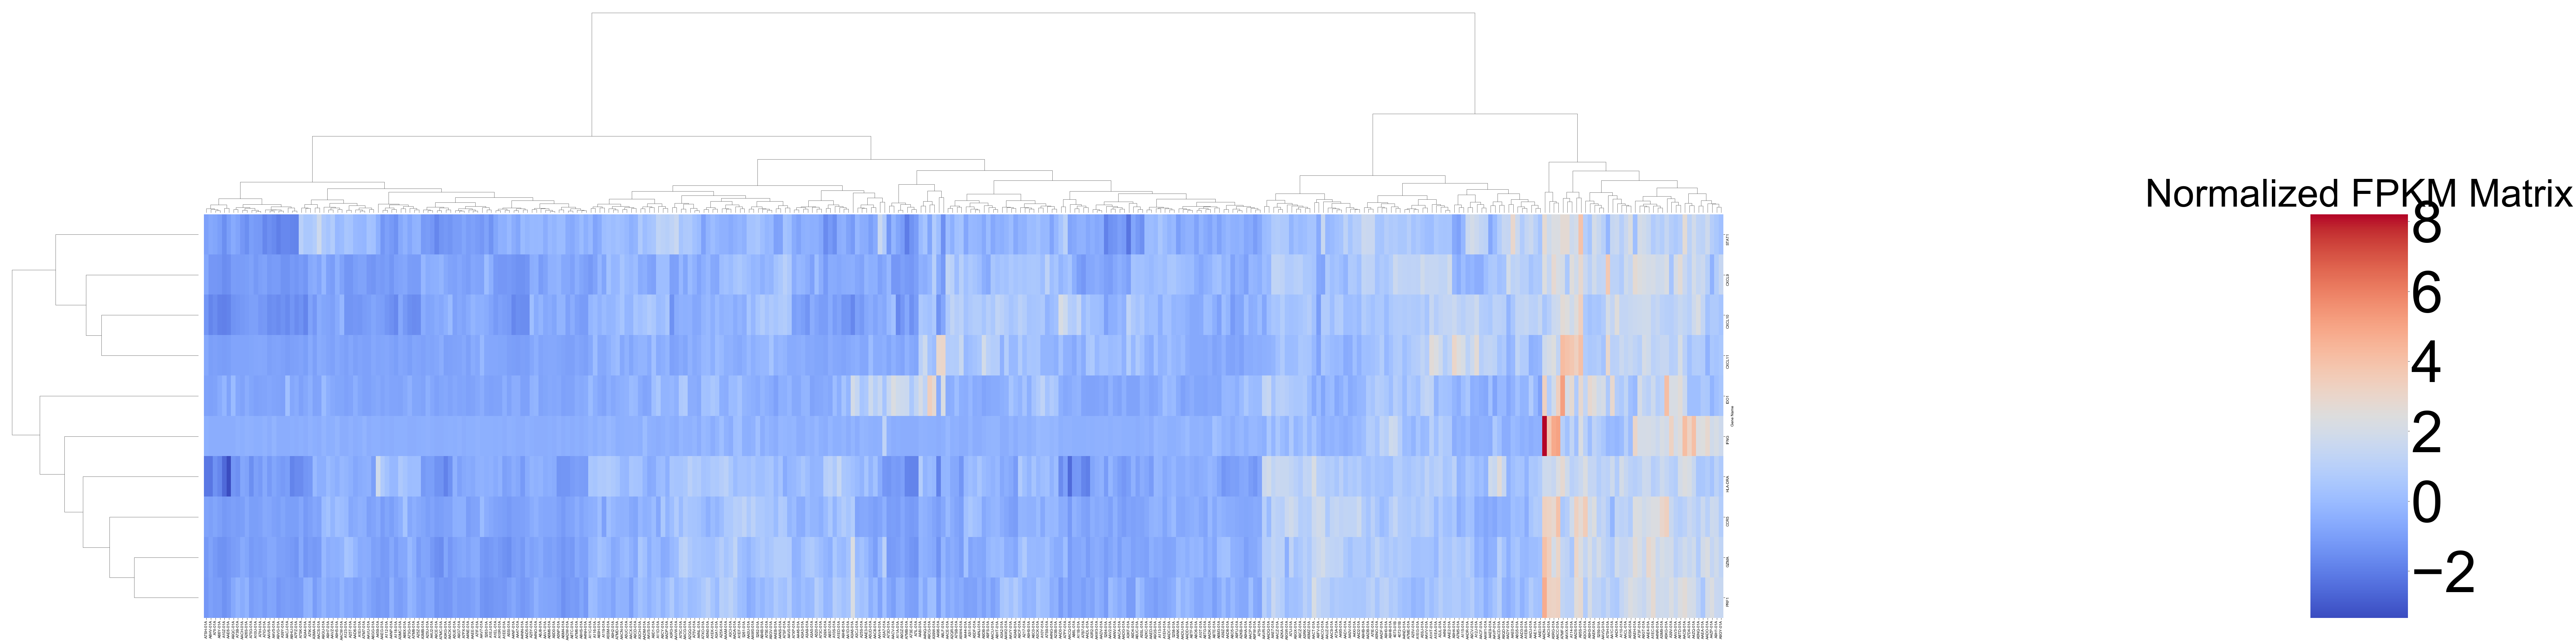

In [79]:
dataf, cm = plot_data(data=df, precomp=False, method="ward", metric="euclidean", cmap="coolwarm", figsize=(80, 20))

## Gene clusters
##### Select threshold for wanted number of gene clusters

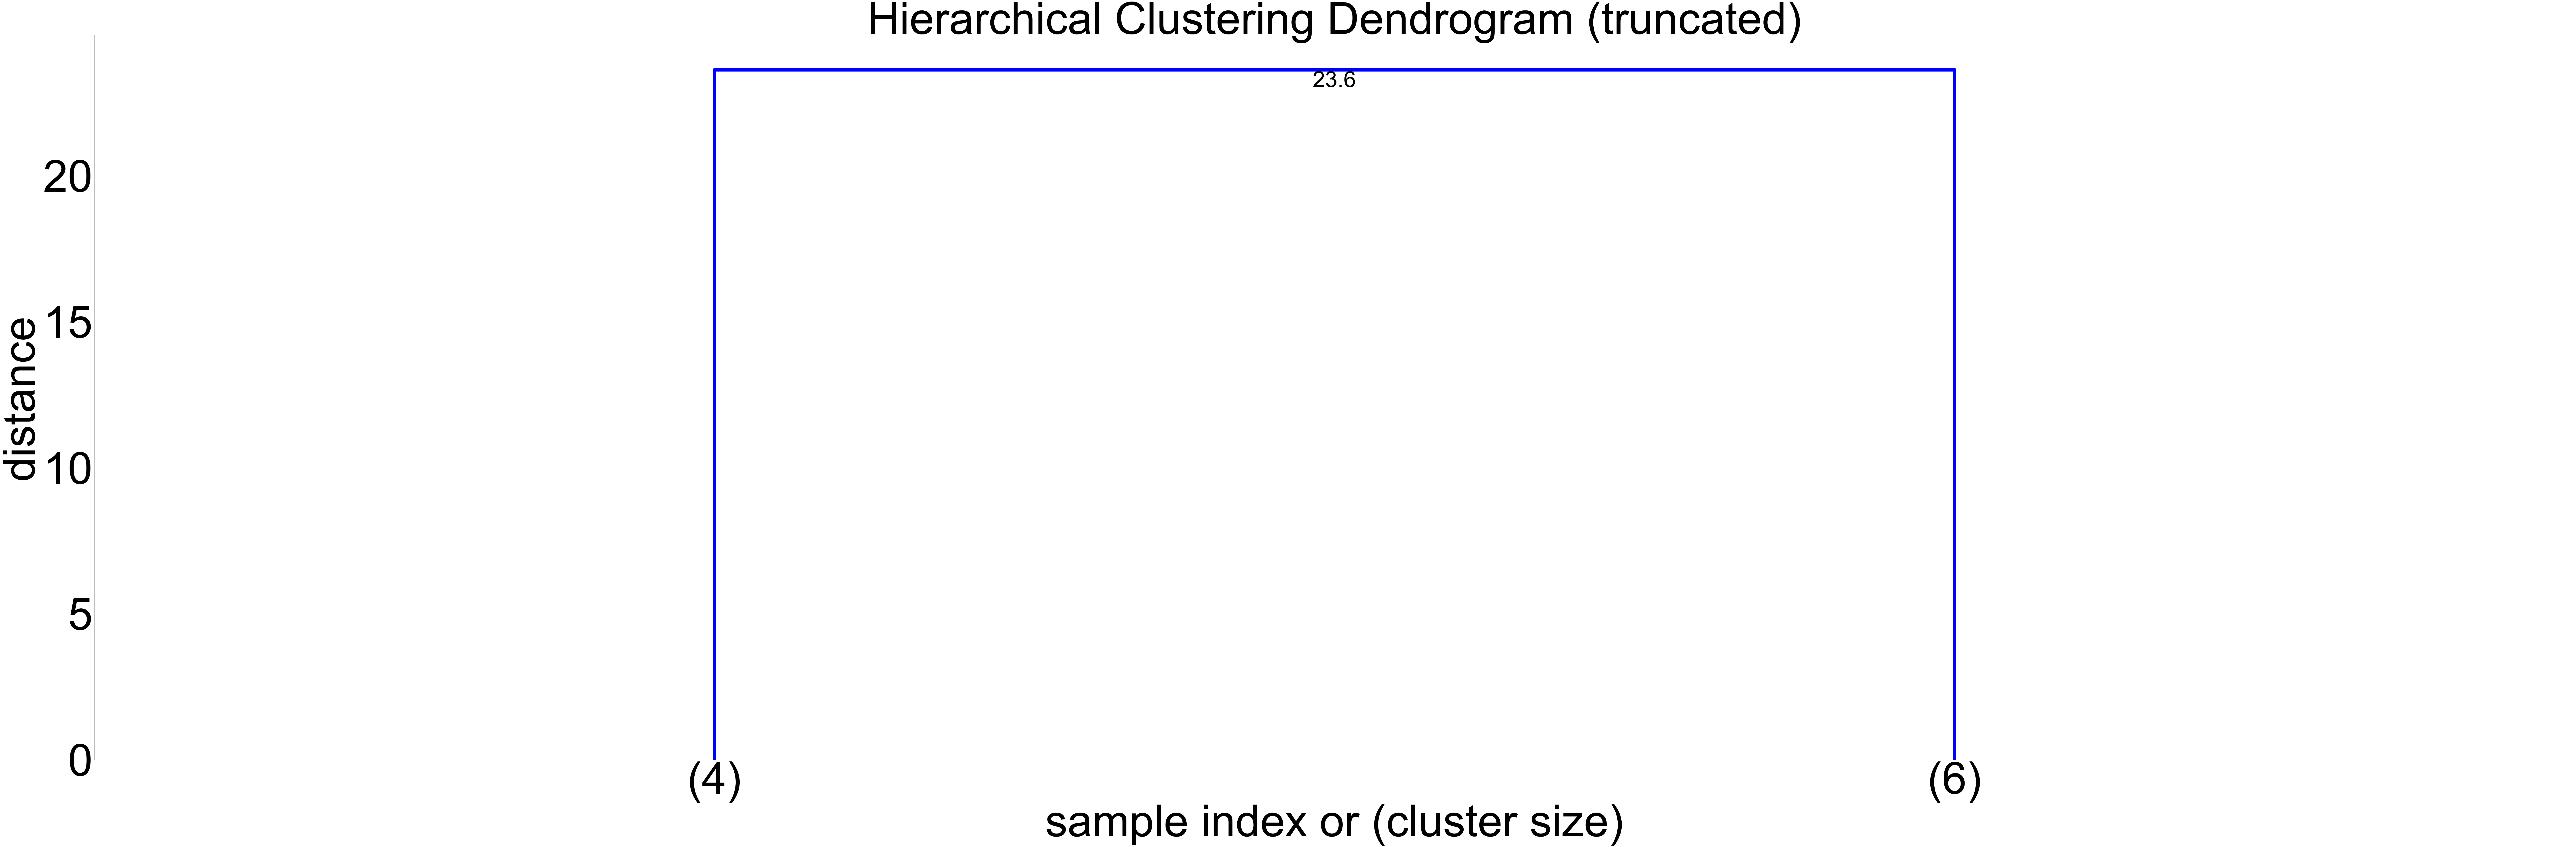

In [80]:
# pass p -- wanted cluster number to fancy_dendrogram and check the truncated dendrogram for threshold
plt.figure(figsize=(200, 60))
plt.rcParams['lines.linewidth'] = 15
fancy_dendrogram(cm.dendrogram_row.linkage, orientation='top', show_leaf_counts=True, truncate_mode='lastp', 
                 p=2, show_contracted=False, leaf_font_size=120, annotate_above=5)
# plt.savefig("../results/tcga_python/dendrogram_gene_{}_zscore_ward_euclidean_truncated.png".format(signature), dpi=30)
plt.show()

##### Retrieve gene clusters (input a threshold)

In [81]:
# the threshold should be a value slightly small than the observed threshold
clusters_row, genes_clustered = retrieve_cluster(data=df, cm=cm, gene_or_sample="gene", threshold=23)
# genes_clustered.to_csv("../results/tcga_python/gene_clusters_{}_zscore_hc_ward_euclidean_3.csv".format(signature), index=False)

[2 1 1 1 2 2 2 2 2 1]
(10, 2)


,Name,Cluster
0,CXCL10,1
1,CXCL11,1
2,CXCL9,1
3,STAT1,1
4,CCR5,2


## Sample clusters
##### Select threshold for wanted number of sample clusters

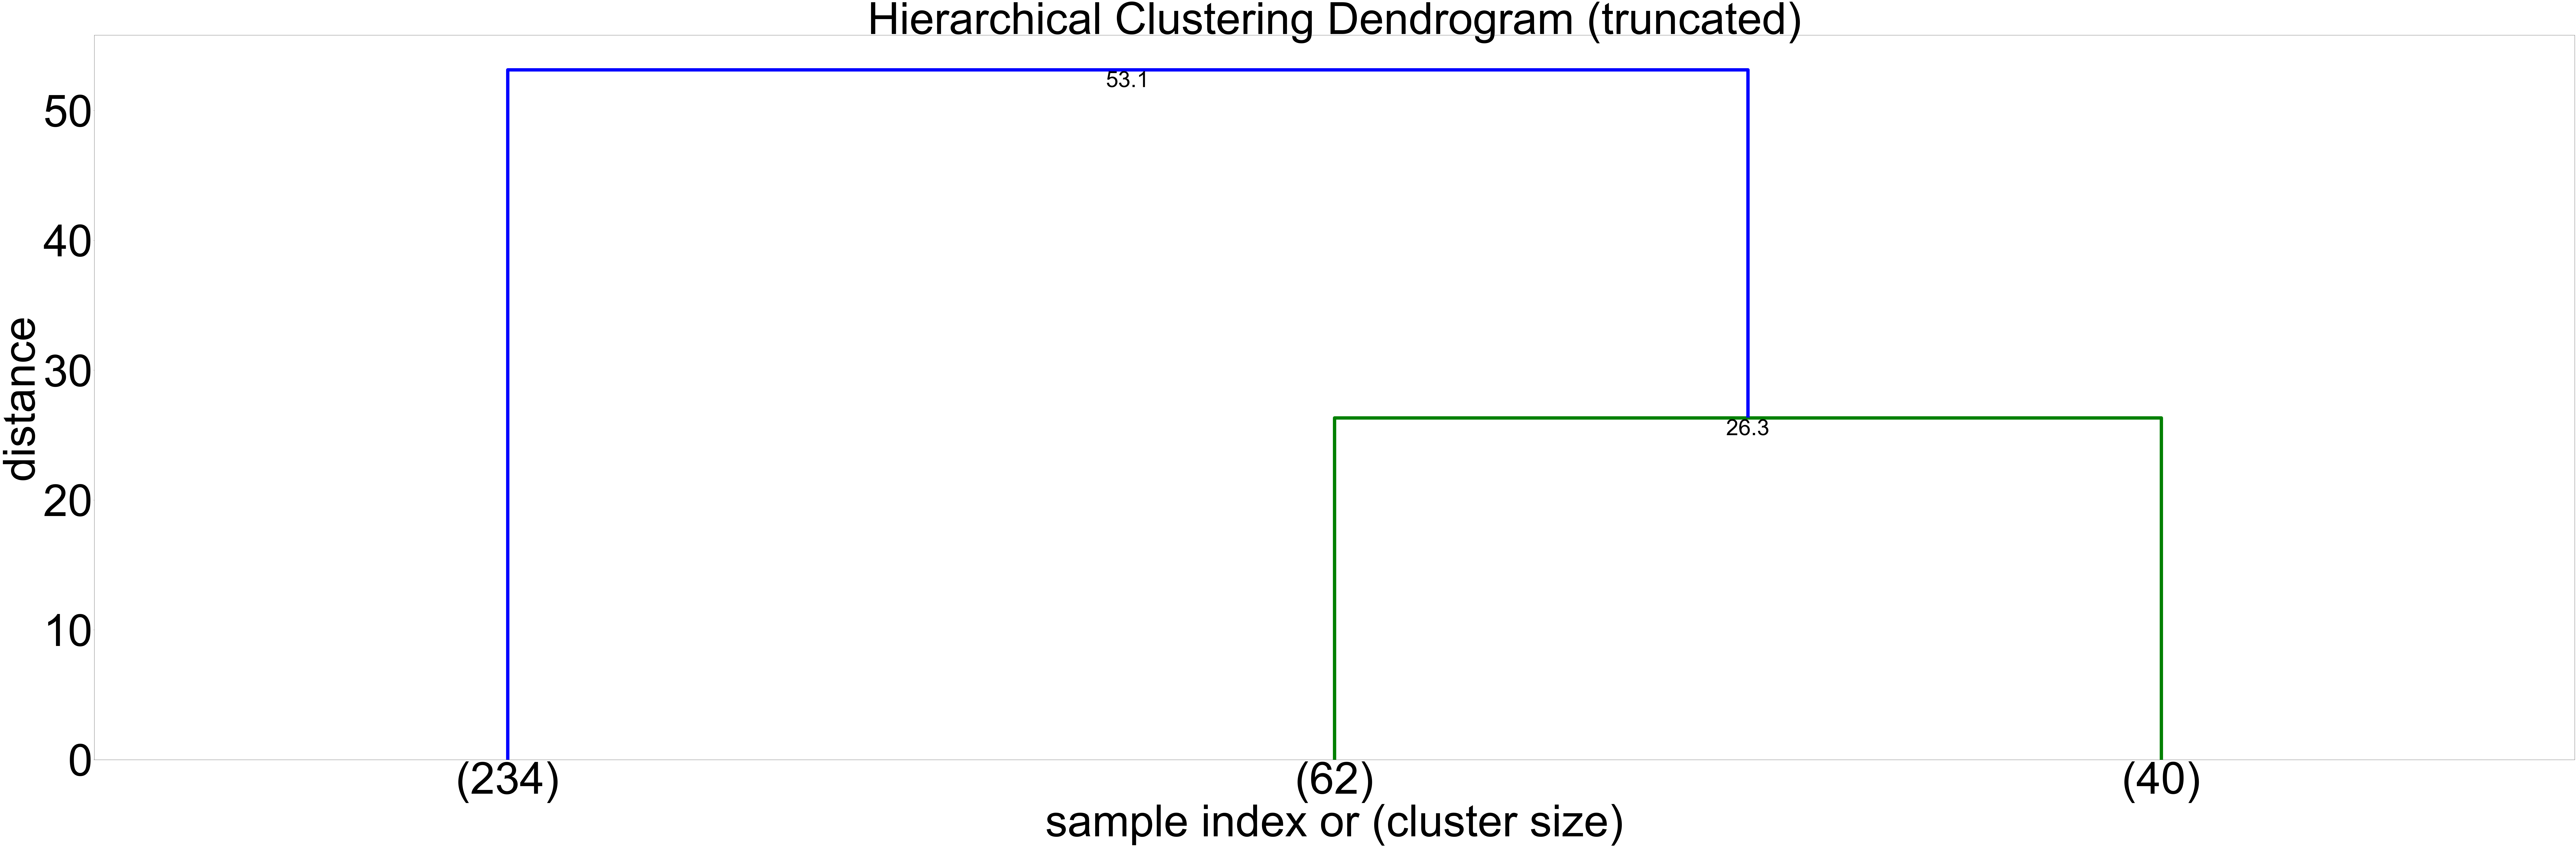

In [82]:
# pass p -- wanted cluster number to fancy_dendrogram and check the truncated dendrogram for threshold
plt.figure(figsize=(200, 60))
plt.rcParams['lines.linewidth'] = 15
fancy_dendrogram(cm.dendrogram_col.linkage, orientation='top', show_leaf_counts=True, truncate_mode='lastp', 
                 p=3, show_contracted=False, leaf_font_size=120, annotate_above=5)
# plt.savefig("../results/tcga_python/dendrogram_sample_{}_zscore_ward_euclidean_truncated.png".
#              format(signature), dpi=30)
plt.show()

##### Retrieve and export sample clusters (input a threshold and set cluster name)
Sometimes could be hard to tell which is Cluster Median

In [85]:
# the threshold should be a value slightly small than the observed threshold
clusters_col, sample_clustered = retrieve_cluster(data=df, cm=cm, gene_or_sample="sample", threshold=26) # threshold=48

# rename clusters for heatmap
clusters_col.replace(1, 'Cluster Low', inplace=True)
clusters_col.replace(2, 'Cluster Median', inplace=True)
clusters_col.replace(3, 'Cluster High', inplace=True)

# rename clusters to export
sample_clustered.replace(1, 'Cluster Low', inplace=True)
sample_clustered.replace(2, 'Cluster Median', inplace=True)
sample_clustered.replace(3, 'Cluster High', inplace=True)

display(sample_clustered.head(3))
sample_clustered.to_csv("../results/tcga_python/sample_clusters_{}_zscore_hc_ward_euclidean_3.csv".format(signature), 
                        index=False)

[2 2 1 2 2 3 1 1 1 1 1 1 1 1 1 3 1 1 1 2 1 3 1 1 1 1 1 1 1 1 2 2 1 3 3 1 3
 2 1 2 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 3 1 1 3 2 1
 1 1 1 1 1 3 1 1 3 3 1 1 1 1 1 1 1 1 1 1 3 1 3 2 1 1 2 1 1 1 1 1 1 2 2 1 1
 1 1 2 1 1 2 1 3 1 1 1 2 2 1 1 1 2 1 1 2 1 2 1 3 2 1 1 1 2 1 2 1 1 1 1 1 1
 2 1 1 1 1 1 3 1 1 2 1 2 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1
 1 1 1 3 1 1 1 1 1 3 1 1 1 1 1 1 3 1 1 2 1 1 2 1 3 1 1 1 1 1 1 2 1 1 1 1 1
 1 2 1 1 1 2 2 1 1 3 1 2 1 3 1 1 2 1 1 2 1 1 1 1 1 1 2 2 2 1 2 1 2 3 1 1 1
 1 2 3 1 1 2 3 1 1 1 1 3 1 1 2 3 1 1 1 2 1 3 1 1 1 3 1 1 1 1 1 1 2 1 1 2 3
 1 3 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 3 1 1 1 3 3 3 1 1 1 1 3 1 2 1 1 3 2 1
 2 2 3]
(336, 2)


,Name,Cluster
0,AACU-01A,1
1,A8HU-01A,1
2,A8O6-01A,1
3,A7SK-01A,1
4,A73E-01A,1


,Name,Cluster
0,AACU-01A,Cluster Low
1,A8HU-01A,Cluster Low
2,A8O6-01A,Cluster Low


##### Final clustered heatmap

In [86]:
# Ta-da! The nice final version
plot_data(data=df, method="ward", clusters_row=clusters_row, clusters_col=clusters_col, cmap="coolwarm") # The Ward’s linkage supports only the Euclidean distance

['Arial']


(           4073-01B  A4XI-01A  AACU-01A  AACT-01A  AADJ-01A  A9H1-01A  \
 Gene Name                                                               
 CCR5       1.383557  1.276356 -0.235262  1.642916  0.444380  1.646571   
 CXCL10     0.750033  0.248345  0.563375  0.227171  1.112707  0.703566   
 CXCL11     0.690372  0.155589  0.845681 -0.112943 -0.408503  0.372284   
 CXCL9      1.685038  0.648260  0.456849  0.385951  0.341755  0.810778   
 GZMA       0.532850  0.697116  0.003368  1.383361  0.046341  1.879213   
 HLA-DRA    0.832424  0.569534 -0.332923  2.184445  0.561343  1.167312   
 IDO1       0.927136 -0.447314 -0.617346 -0.611439  0.750502  0.190050   
 IFNG       1.691389 -0.025412 -0.264460  0.441065 -0.498995  2.122198   
 PRF1       0.852813  0.480163 -0.920021  2.163187  0.779558  1.600371   
 STAT1      0.736990  0.920729 -0.682740  0.392652  1.643974  0.571536   
 
            A8HU-01A  A8O6-01A  A7SK-01A  A73E-01A  ...  AAD8-01A  A7IJ-01A  \
 Gene Name                     